In [1]:

import numpy as np
import pandas as pd
import networkx as nx
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline


## BTC transactions

In [87]:
data_matrix = pd.read_csv('data/BTC_OTC.csv',names = ['From','To','Rating','Timestamp'])

In [3]:
data_matrix.head()

,From,To,Rating,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


## EDA

# --Distibution of Ratings

Text(0, 0.5, 'Frequency')

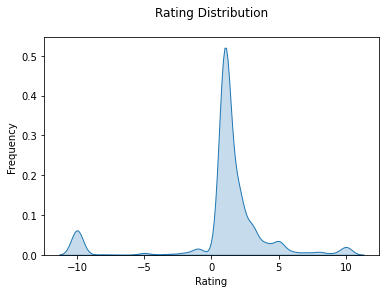

In [4]:
# ratings distribution
sns.kdeplot(data_matrix['Rating'], shade = True)
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Frequency')

<AxesSubplot:>

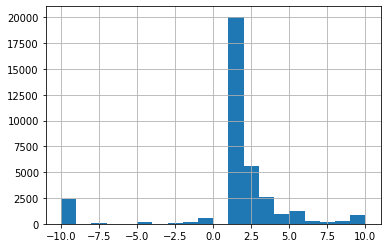

In [5]:
data_matrix['Rating'].hist(bins=20)

In [6]:
data_matrix[data_matrix["Rating"]==1].shape[0]

20048

In [7]:
ratings={"Rating":[],
    "#Nodes":[]}
for i in set(data_matrix["Rating"]):
    print(i,data_matrix[data_matrix["Rating"]==i].shape[0])
    ratings["Rating"].append(i)
    ratings["#Nodes"].append(data_matrix[data_matrix["Rating"]==i].shape[0])

1 20048
2 5562
3 2561
4 967
5 1268
6 265
7 208
8 277
9 108
10 765
-7 14
-10 2413
-9 20
-8 31
-1 601
-6 5
-5 179
-4 27
-3 91
-2 182


### Generate table for the paper 

In [8]:
pd.DataFrame.from_dict(ratings).sort_values("Rating",ascending=False)

,Rating,#Nodes
9,10,765
8,9,108
7,8,277
6,7,208
5,6,265
4,5,1268
3,4,967
2,3,2561
1,2,5562
0,1,20048


In [9]:
ratings

{'Rating': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  -7,
  -10,
  -9,
  -8,
  -1,
  -6,
  -5,
  -4,
  -3,
  -2],
 '#Nodes': [20048,
  5562,
  2561,
  967,
  1268,
  265,
  208,
  277,
  108,
  765,
  14,
  2413,
  20,
  31,
  601,
  5,
  179,
  27,
  91,
  182]}

/home/ml-lab/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '-10'),
  Text(1, 0, '-5'),
  Text(2, 0, '-3'),
  Text(3, 0, '-2'),
  Text(4, 0, '-1'),
  Text(5, 0, '1'),
  Text(6, 0, '2'),
  Text(7, 0, '3'),
  Text(8, 0, '4'),
  Text(9, 0, '5'),
  Text(10, 0, '6'),
  Text(11, 0, '7'),
  Text(12, 0, '8'),
  Text(13, 0, '9'),
  Text(14, 0, '10')])

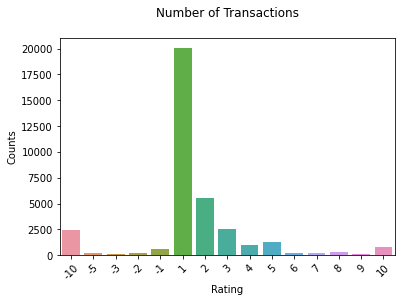

In [10]:
# number of edges per rating
sns.barplot(data_matrix['Rating'].value_counts().head(15).index, data_matrix['Rating'].value_counts().head(15))
plt.title('Number of Transactions\n')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# Ratings vs. From Nodes (Dist of Ratings)

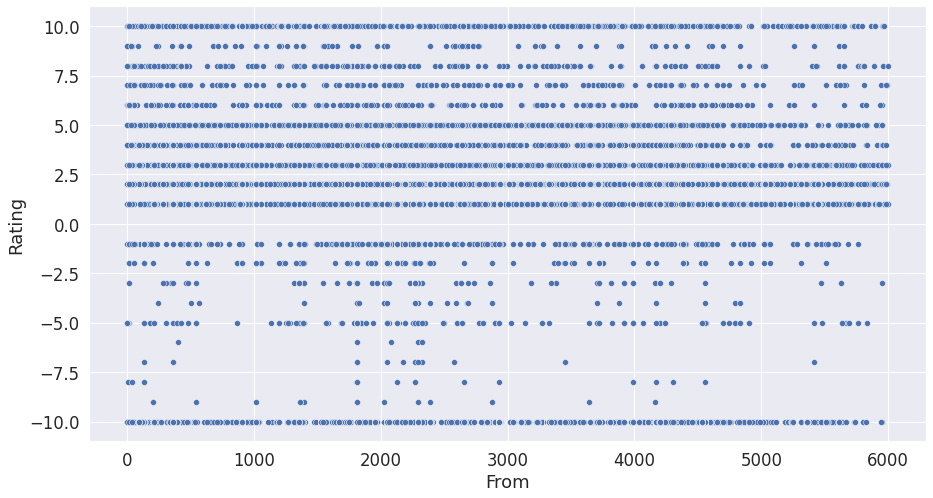

In [11]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = data_matrix.From,y= data_matrix.Rating)

It can be seen from the above plot that most of the source nodes have given positive rating and it very concentrated. This gives the intuition of creating two features fairness and goodness which will be discussed below.

# Graph

In [12]:
G = nx.DiGraph()
edges=[(data_matrix["From"][i],data_matrix["To"][i],data_matrix["Rating"][i]/10) for i in data_matrix.index]
edges

[(6, 2, 0.4),
 (6, 5, 0.2),
 (1, 15, 0.1),
 (4, 3, 0.7),
 (13, 16, 0.8),
 (13, 10, 0.8),
 (7, 5, 0.1),
 (2, 21, 0.5),
 (2, 20, 0.5),
 (21, 2, 0.5),
 (21, 1, 0.8),
 (21, 10, 0.8),
 (21, 8, 0.9),
 (21, 3, 0.7),
 (17, 3, 0.5),
 (17, 23, 0.1),
 (10, 1, 0.8),
 (10, 6, 0.7),
 (10, 21, 0.8),
 (10, 8, 0.1),
 (10, 25, 1.0),
 (10, 2, 0.7),
 (10, 3, 0.7),
 (4, 26, 0.1),
 (26, 4, 0.1),
 (5, 1, 0.3),
 (5, 6, 0.3),
 (5, 7, 0.1),
 (1, 5, 0.4),
 (6, 4, 0.2),
 (4, 6, 0.5),
 (2, 4, 0.5),
 (17, 28, 0.1),
 (17, 13, 0.2),
 (13, 17, 0.2),
 (13, 29, 0.2),
 (29, 13, 0.2),
 (17, 20, 0.2),
 (4, 31, 0.1),
 (31, 4, 0.2),
 (32, 6, 0.1),
 (13, 1, 0.8),
 (7, 34, 0.1),
 (34, 7, 0.1),
 (32, 1, 0.1),
 (1, 32, 0.1),
 (1, 34, 0.1),
 (34, 1, 0.1),
 (34, 13, 0.1),
 (13, 34, 0.1),
 (6, 7, 0.5),
 (7, 6, 0.3),
 (1, 17, 0.9),
 (1, 31, 0.2),
 (31, 1, 0.3),
 (35, 6, 0.2),
 (1, 13, 0.3),
 (36, 37, 0.1),
 (37, 36, 0.1),
 (35, 1, 0.1),
 (17, 1, 0.9),
 (8, 1, 0.3),
 (7, 29, 0.2),
 (1, 20, 0.2),
 (37, 44, 0.1),
 (44, 37, 0.1),
 (39, 

In [13]:
for edge in edges:
    G.add_edge(edge[0],edge[1],weight=edge[2])

In [14]:
print(len(G.edges()))
print(len(G.nodes()))

35592
5881


## Feature Engineering

In [15]:
def initialize_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='weight')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness

# Features

In [22]:
def compute_fairness_goodness(G):
    fairness, goodness = initialize_scores(G)
    
    nodes = G.nodes()

    while True:
        df = 0
        dg = 0

        print("Iteration number", iter)
        
        print('Updating goodness')
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        print('Updating fairness')
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        
    
    return fairness, goodness

In [23]:
# these two dictionaries have the required scores
fairness, goodness = compute_fairness_goodness(G)

Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Iteration number <built-in function iter>
Updating goodness
Upda

## Visualisation

In [24]:
a= [i for i,j in fairness.items() ]
b = [j for i,j in fairness.items()]


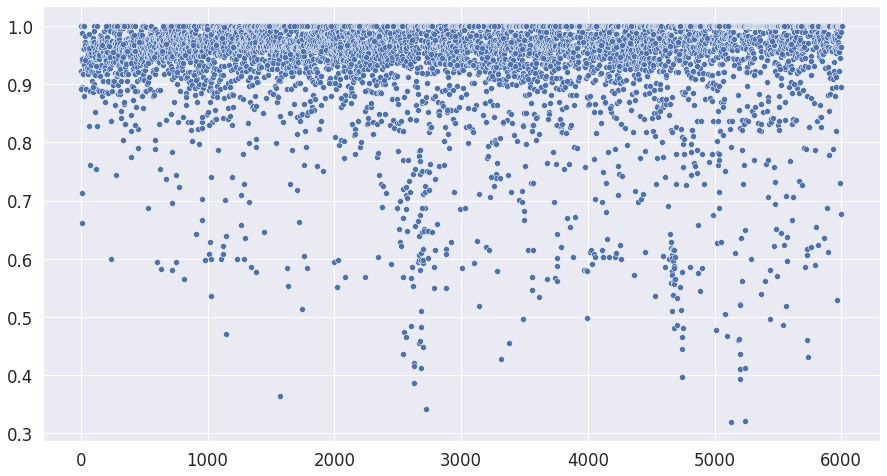

In [25]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = list(a),y= list(b))

# Appending Results to Matrix

## Fairness to Matrix

In [28]:
def Fairness(row): return fairness[row]
df=data_matrix.copy()
df['fairness'] = df['From'].apply(Fairness)

### Goodness to Matrix 

In [29]:
def Goodness(row): return goodness[row]
df['goodness'] = df['To'].apply(Goodness)

In [30]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness
0,6,2,4,1.289242e+09,0.895726,0.269531
1,6,5,2,1.289242e+09,0.895726,0.214168
2,1,15,1,1.289243e+09,0.922436,0.144465
3,4,3,7,1.289245e+09,0.891287,-0.035796
4,13,16,8,1.289254e+09,0.945563,0.756450


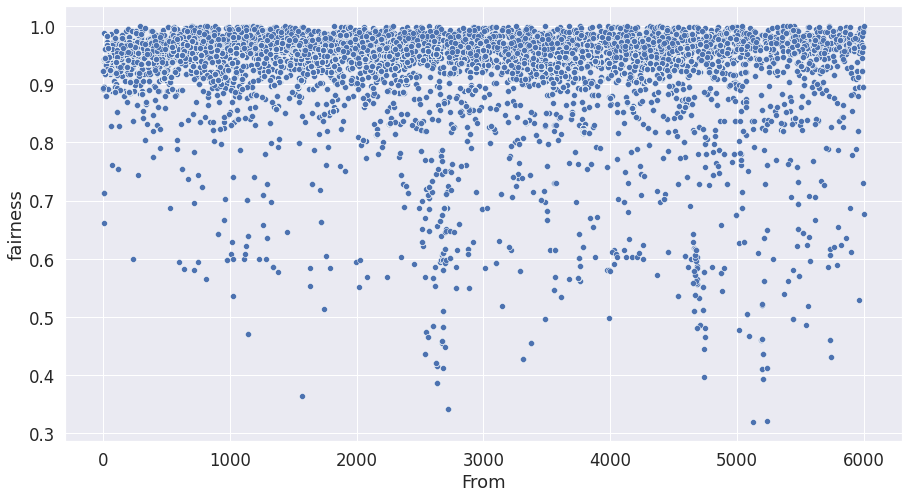

In [31]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = df.From,y= df.fairness)

# Betweenness

In [33]:
from tqdm import tqdm_notebook as tqdm

def betweenness_centrality(G):
    
    V=G.nodes()
    pbar=tqdm(total=len(V))
    btw={}
    for s in V:
        btw[s]=0.0
    for s  in V:
        pbar.update(1)
        #single-source shortest paths problem
        #initialization
        pred={}
        dist={}
        sigma={}
        Q=[]
        stack=[]
        for w in V:
            pred[w]=[]
            dist[w]=-1
            sigma[w]=0
            
        dist[s]=0
        sigma[s]=1
        Q.append(s)
        
        while len(Q)!=0:
            v=Q.pop(0)
            stack.append(v)
            for w in G.neighbors(v):
                #path discovery
                if dist[w]==-1:
                    dist[w]=dist[v]+1
                    
                    Q.append(w)
                #path counting
                if dist[w]==dist[v]+1:
                    sigma[w]=sigma[w]+sigma[v]
                    dist[w]=dist[v]+1
                    
                    pred[w].append(v)
        #accumulation
        delta={}
        for v in V:
            delta[v]=0
        while len(stack)!=0:
            w=stack.pop()
            for v in pred[w]:
                delta[v]=delta[v]+(sigma[v]/sigma[w])*(1+delta[w])
            if w !=s:
                btw[w]=btw[w]+delta[w]
        
    return btw
            
           

In [34]:
G2 = G.to_undirected()

In [35]:
len(nx.Graph(G).edges)

21492

In [36]:
btw_centrality=betweenness_centrality(G)

/tmp/ipykernel_664018/4108008526.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar=tqdm(total=len(V))


  0%|          | 0/5881 [00:00<?, ?it/s]

In [38]:
max_value=max(btw_centrality.values())

### Add Betweenness to Matrix

In [39]:
df["btw_From"]=0.
df["btw_To"]=0.
df["btw"]=0.

for i in df.index:
    df["btw"][i]=((btw_centrality[(df["From"][i])]+btw_centrality[(df["To"][i])])/2)/max_value
    df["btw_From"][i]=btw_centrality[(df["From"][i])]/max_value
    df["btw_To"][i]=btw_centrality[(df["To"][i])]/max_value

/tmp/ipykernel_664018/2035661013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw"][i]=((btw_centrality[(df["From"][i])]+btw_centrality[(df["To"][i])])/2)/max_value
/tmp/ipykernel_664018/2035661013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw_From"][i]=btw_centrality[(df["From"][i])]/max_value
/tmp/ipykernel_664018/2035661013.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw_To"][i]=btw_centrality[(d

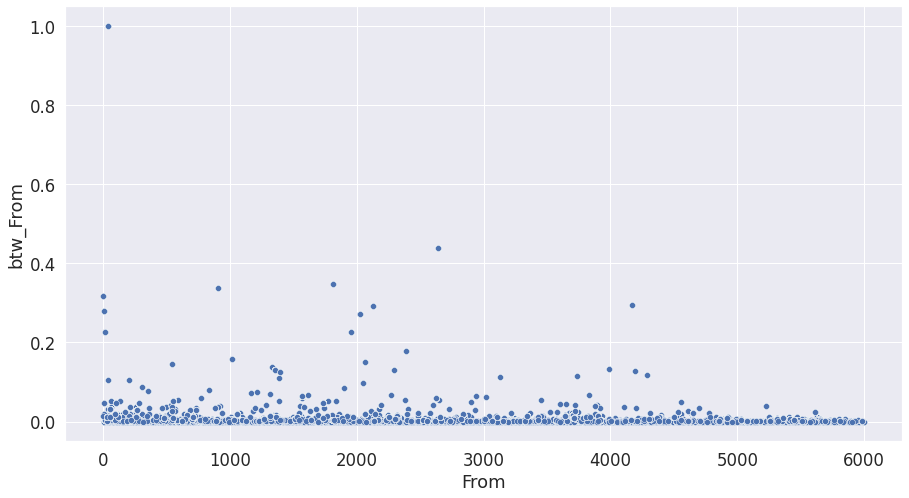

In [40]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = df.From,y= df.btw_From)

# Closenness

In [41]:
closeenness=nx.algorithms.closeness_centrality(G)

In [43]:
df["C_From"]=0.
df["C_To"]=0.
df["C"]=0.

for i in df.index:
    df["C"][i]=((closeenness[(df["From"][i])]+closeenness[(df["To"][i])])/2)
    df["C_From"][i]=closeenness[(df["From"][i])]
    df["C_To"][i]=closeenness[(df["To"][i])]

/tmp/ipykernel_664018/2958500815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C"][i]=((closeenness[(df["From"][i])]+closeenness[(df["To"][i])])/2)
/tmp/ipykernel_664018/2958500815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C_From"][i]=closeenness[(df["From"][i])]
/tmp/ipykernel_664018/2958500815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C_To"][i]=closeenness[(df["To"][i])]


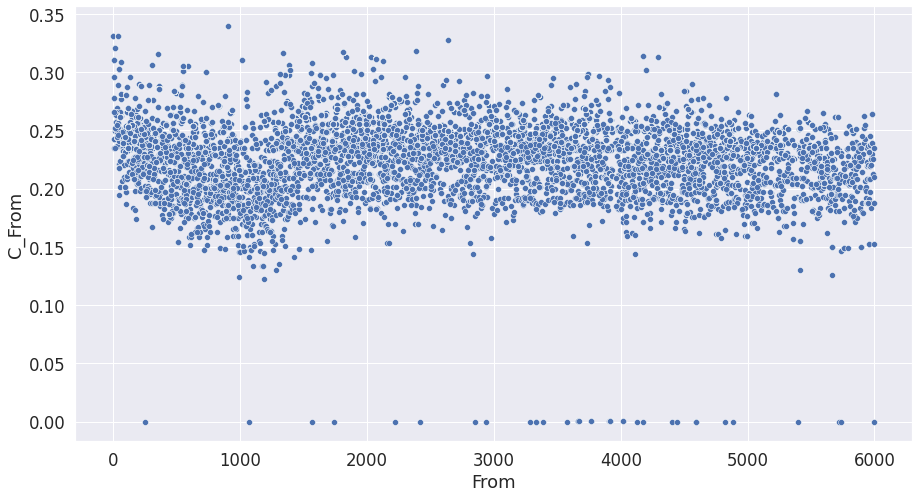

In [44]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = df.From,y= df.C_From)

### Degree Centrality

In [45]:
df["DC_From"]=0.
df["DC_To"]=0.
df["DC"]=0.
degree_centrality=nx.degree_centrality(G)

for i in df.index:
    df["DC"][i]=((degree_centrality[(df["From"][i])]+degree_centrality[(df["To"][i])])/2)
    df["DC_From"][i]=degree_centrality[(df["From"][i])]
    df["DC_To"][i]=degree_centrality[(df["To"][i])]

/tmp/ipykernel_664018/3483378970.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DC"][i]=((degree_centrality[(df["From"][i])]+degree_centrality[(df["To"][i])])/2)
/tmp/ipykernel_664018/3483378970.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DC_From"][i]=degree_centrality[(df["From"][i])]
/tmp/ipykernel_664018/3483378970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DC_To"][i]=degree_centrality[(df["To"][i])

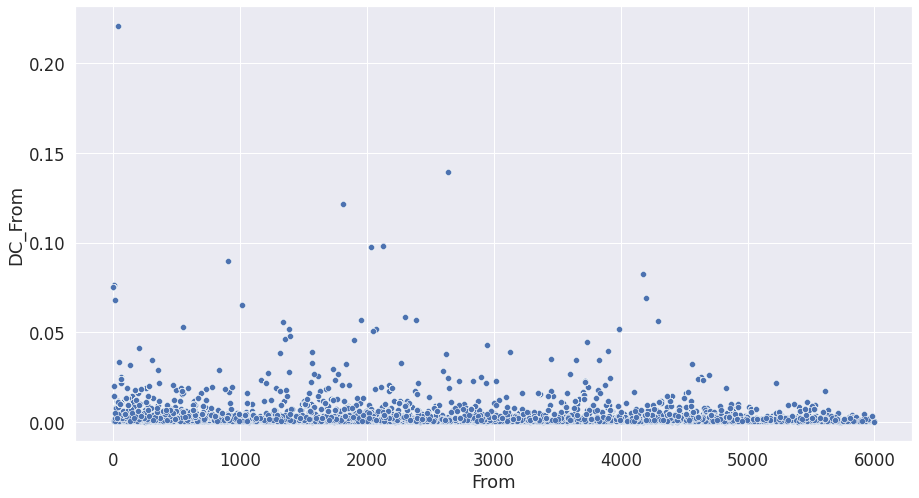

In [46]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = df.From,y= df.DC_From)

# Applying SL Models

## Creating X and y 

In [47]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness,btw_From,btw_To,btw,C_From,C_To,C,DC_From,DC_To,DC
0,6,2,4,1.289242e+09,0.895726,0.269531,0.018029,0.014119,0.016074,0.296063,0.265506,0.280785,0.014286,0.014626,0.014456
1,6,5,2,1.289242e+09,0.895726,0.214168,0.018029,0.000000,0.009015,0.296063,0.242396,0.269230,0.014286,0.001020,0.007653
2,1,15,1,1.289243e+09,0.922436,0.144465,0.316636,0.004795,0.160715,0.330994,0.251884,0.291439,0.075000,0.004762,0.039881
3,4,3,7,1.289245e+09,0.891287,-0.035796,0.045986,0.000000,0.022993,0.278002,0.262725,0.270364,0.019898,0.003571,0.011735
4,13,16,8,1.289254e+09,0.945563,0.756450,0.226833,0.000000,0.113416,0.320739,0.229434,0.275087,0.068197,0.000170,0.034184


In [48]:
df[['From', 'To', 'Rating', 'fairness', 'goodness', 'btw',
       'btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC']].head(5)

,From,To,Rating,fairness,goodness,btw,btw_From,btw_To,C_From,C_To,C,DC_From,DC_To,DC
0,6,2,4,0.895726,0.269531,0.016074,0.018029,0.014119,0.296063,0.265506,0.280785,0.014286,0.014626,0.014456
1,6,5,2,0.895726,0.214168,0.009015,0.018029,0.000000,0.296063,0.242396,0.269230,0.014286,0.001020,0.007653
2,1,15,1,0.922436,0.144465,0.160715,0.316636,0.004795,0.330994,0.251884,0.291439,0.075000,0.004762,0.039881
3,4,3,7,0.891287,-0.035796,0.022993,0.045986,0.000000,0.278002,0.262725,0.270364,0.019898,0.003571,0.011735
4,13,16,8,0.945563,0.756450,0.113416,0.226833,0.000000,0.320739,0.229434,0.275087,0.068197,0.000170,0.034184


In [49]:

X=np.array(df[['fairness', 'goodness', 'btw',
       'btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC']])
y=np.array(df["Rating"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)

## Splitting data into test , train and validation

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)

In [51]:
ss={
    
    1:["From","To"],
    2: ['fairness', 'goodness', 'btw',
       'btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
    3:['fairness', 'goodness'],
    4:['fairness', 'goodness', 'btw',
       'btw_From', 'btw_To'],
    5:['fairness', 'goodness', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
    6:[
       'btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
    7: [ 'DC_From', 'DC_To', 'DC']
    
}

## Using Logistic Regression 

In [52]:
X_train

array([[ 0.95871912, -0.04002892,  0.02335824, ...,  0.00391156,
         0.02295918,  0.01343537],
       [ 0.93182308,  0.15337876,  0.14648485, ...,  0.09812925,
         0.00102041,  0.04957483],
       [ 0.93182308,  0.08271542,  0.14753342, ...,  0.09812925,
         0.00493197,  0.05153061],
       ...,
       [ 0.89934237,  0.14167133,  0.00477932, ...,  0.00408163,
         0.00884354,  0.00646259],
       [ 0.9590586 ,  0.0928675 ,  0.00556598, ...,  0.00833333,
         0.01156463,  0.00994898],
       [ 0.92243642,  0.18509622,  0.15993877, ...,  0.075     ,
         0.00255102,  0.03877551]])

In [53]:
LogisticRegression??

In [54]:
all_results={}

In [56]:
lg_results={}
for s in tqdm(ss):
    col=ss[s]
    X=np.array(df[col])
    y=np.array(df["Rating"])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
    lg_results[s]={}
    print(s)
    
        
    lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
    lg.fit(X_train,y_train)
    #print("Validation Accuracy is: ")
    #print(lg.score(X_val,y_val))
    #print("\n\n======================\n\n")
    #print("Test accuracy is: ")
    predictions=lg.predict(X_test)
    lg.score(X_test,y_test)
    lg_results[s]=round(lg.score(X_test,y_test),2)
    print(lg_results[s])

/tmp/ipykernel_664018/4270235948.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(ss):


  0%|          | 0/7 [00:00<?, ?it/s]

1


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.56
2


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6
3


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6
4


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6
5


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6
6


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.56
7
0.56


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
all_results["Logistic Regression"]=lg_results
all_results

{'Logistic Regression': {1: 0.56,
  2: 0.6,
  3: 0.6,
  4: 0.6,
  5: 0.6,
  6: 0.56,
  7: 0.56}}

### Plot best model 

5


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:title={'center':'Logistic Regression '}>

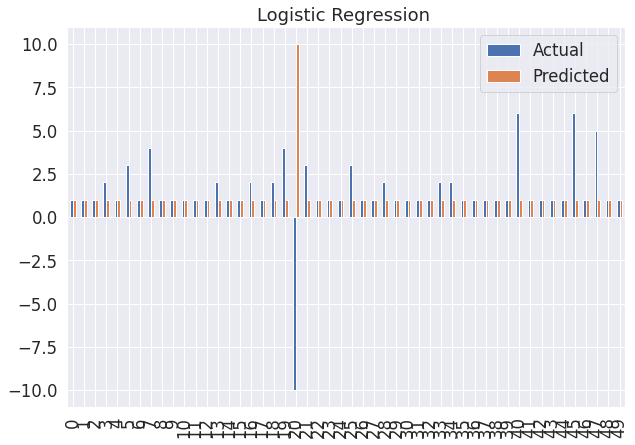

In [58]:
s=5
col=ss[s]
X=np.array(df[col])
y=np.array(df["Rating"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
lg_results[s]={}
print(s)


lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
lg.fit(X_train,y_train)
#print("Validation Accuracy is: ")
#print(lg.score(X_val,y_val))
#print("\n\n======================\n\n")
#print("Test accuracy is: ")
predictions=lg.predict(X_test)
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(50)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(10, 7),title="Logistic Regression ")

## Using Random Forest Classifier

In [60]:
RF_results={}
for s in tqdm(ss):
    col=ss[s]
    X=np.array(df[col])
    y=np.array(df["Rating"])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
    RF_results[s]={}
    print(s)
    
        
    classifier = RandomForestClassifier(n_estimators=500,criterion= 'entropy',random_state = 0)
    classifier.fit(X_train,y_train)
    predictions=classifier.predict(X_test)

    
    RF_results[s]=round(classifier.score(X_test,y_test),2)
    print(RF_results[s])

/tmp/ipykernel_664018/4254152825.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(ss):


  0%|          | 0/7 [00:00<?, ?it/s]

1
0.51
2
0.63
3
0.58
4
0.61
5
0.63
6
0.57
7
0.48


In [61]:
all_results["Random Forest Classifier"]=RF_results
all_results

{'Logistic Regression': {1: 0.56,
  2: 0.6,
  3: 0.6,
  4: 0.6,
  5: {},
  6: 0.56,
  7: 0.56},
 'Random Forest Classifier': {1: 0.51,
  2: 0.63,
  3: 0.58,
  4: 0.61,
  5: 0.63,
  6: 0.57,
  7: 0.48}}

<AxesSubplot:title={'center':'Random Forest Classifier'}>

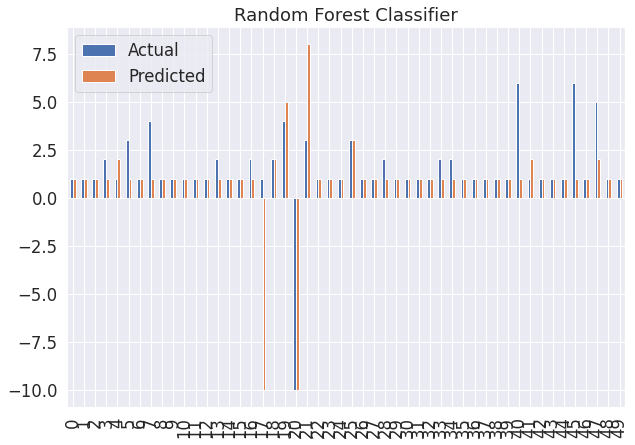

In [62]:
s=5
col=ss[s]
X=np.array(df[col])
y=np.array(df["Rating"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
classifier = RandomForestClassifier(n_estimators=500,criterion= 'entropy',random_state = 0)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_test)
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(50)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(10, 7),title="Random Forest Classifier")

In [85]:
pwd

'/media/ml-lab/54436126-1a7a-43dd-bb59-4b8579c3bc67/eth'

## Using Gradient Boosting Algorithm

In [63]:
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)

In [64]:
gb_results={}
for s in ss:
    col=ss[s]
    X=np.array(df[col])
    y=np.array(df["Rating"])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
    gb_results[s]={}
    print(s)
    
        
    gb = GradientBoostingClassifier()
    gb = gb.fit(X_train, y_train)
    predictions=gb.predict(X_test)

    
    gb_results[s]=round(gb.score(X_test,y_test),2)
    print(gb_results[s])

1
0.58
2
0.64
3
0.63
4
0.62
5
0.63
6
0.57
7
0.53


In [65]:
all_results["Gradient Boosting"]=gb_results
all_results

{'Logistic Regression': {1: 0.56,
  2: 0.6,
  3: 0.6,
  4: 0.6,
  5: {},
  6: 0.56,
  7: 0.56},
 'Random Forest Classifier': {1: 0.51,
  2: 0.63,
  3: 0.58,
  4: 0.61,
  5: 0.63,
  6: 0.57,
  7: 0.48},
 'Gradient Boosting': {1: 0.58,
  2: 0.64,
  3: 0.63,
  4: 0.62,
  5: 0.63,
  6: 0.57,
  7: 0.53}}

In [66]:
s=5
col=ss[s]
X=np.array(df[col])
y=np.array(df["Rating"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)
predictions=gb.predict(X_test)

gb.score(X_test,y_test)


0.6325154523318973

<AxesSubplot:title={'center':'Gradient Boosting Algorithm'}>

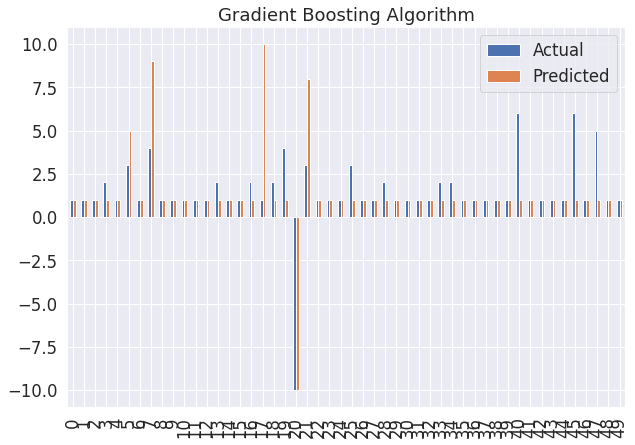

In [67]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(50)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(10, 7),title="Gradient Boosting Algorithm")

# KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

In [74]:
knn_results={}
for s in ss:
    col=ss[s]
    X=np.array(df[col])
    y=np.array(df["Rating"])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
    knn_results[s]={}
    print(s)
    for k in [2,5,10,15,20,25,30,35,50]:
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        print(k,round(metrics.accuracy_score(y_test, y_pred),2))
        knn_results[s][k]=round(metrics.accuracy_score(y_test, y_pred),2)

1
2 0.49
5 0.54
10 0.57
15 0.57
20 0.57
25 0.57
30 0.57
35 0.57
50 0.57
2
2 0.58
5 0.6
10 0.62
15 0.62
20 0.62
25 0.62
30 0.63
35 0.62
50 0.62
3
2 0.57
5 0.59
10 0.61
15 0.62
20 0.62
25 0.62
30 0.62
35 0.62
50 0.62
4
2 0.58
5 0.6
10 0.61
15 0.62
20 0.62
25 0.62
30 0.62
35 0.62
50 0.62
5
2 0.58
5 0.6
10 0.62
15 0.62
20 0.62
25 0.62
30 0.62
35 0.62
50 0.62
6
2 0.5
5 0.53
10 0.56
15 0.56
20 0.57
25 0.57
30 0.57
35 0.57
50 0.57
7
2 0.47
5 0.52
10 0.55
15 0.56
20 0.56
25 0.56
30 0.56
35 0.56
50 0.56


In [78]:
s=5
k=35
col=ss[s]
X=np.array(df[col])
y=np.array(df["Rating"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30,random_state = 20)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 20)
print(s)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print(k,round(metrics.accuracy_score(y_test, y_pred),2))

5
35 0.56


In [79]:
ss[5]

['fairness', 'goodness', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC']

<AxesSubplot:title={'center':'KNN (k=35)'}>

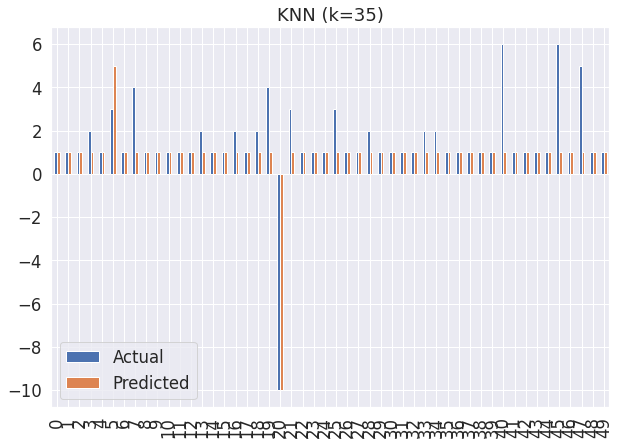

In [80]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(50)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(10, 7),title="KNN (k=35)")

In [81]:
ss

{1: ['From', 'To'],
 2: ['fairness',
  'goodness',
  'btw',
  'btw_From',
  'btw_To',
  'C_From',
  'C_To',
  'C',
  'DC_From',
  'DC_To',
  'DC'],
 3: ['fairness', 'goodness'],
 4: ['fairness', 'goodness', 'btw', 'btw_From', 'btw_To'],
 5: ['fairness', 'goodness', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
 6: ['btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
 7: ['DC_From', 'DC_To', 'DC']}

In [82]:
result_matrix=pd.DataFrame.from_dict(all_results)
result_matrix

,Logistic Regression,Random Forest Classifier,Gradient Boosting
1,0.56,0.51,0.58
2,0.6,0.63,0.64
3,0.6,0.58,0.63
4,0.6,0.61,0.62
5,{},0.63,0.63
6,0.56,0.57,0.57
7,0.56,0.48,0.53


In [83]:
result_matrix_knn=pd.DataFrame.from_dict(knn_results)
result_matrix_knn

,1,2,3,4,5,6,7
2,0.49,0.58,0.57,0.58,0.58,0.50,0.47
5,0.54,0.60,0.59,0.60,0.60,0.53,0.52
10,0.57,0.62,0.61,0.61,0.62,0.56,0.55
15,0.57,0.62,0.62,0.62,0.62,0.56,0.56
20,0.57,0.62,0.62,0.62,0.62,0.57,0.56
25,0.57,0.62,0.62,0.62,0.62,0.57,0.56
30,0.57,0.63,0.62,0.62,0.62,0.57,0.56
35,0.57,0.62,0.62,0.62,0.62,0.57,0.56
50,0.57,0.62,0.62,0.62,0.62,0.57,0.56


In [84]:
ss

{1: ['From', 'To'],
 2: ['fairness',
  'goodness',
  'btw',
  'btw_From',
  'btw_To',
  'C_From',
  'C_To',
  'C',
  'DC_From',
  'DC_To',
  'DC'],
 3: ['fairness', 'goodness'],
 4: ['fairness', 'goodness', 'btw', 'btw_From', 'btw_To'],
 5: ['fairness', 'goodness', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
 6: ['btw_From', 'btw_To', 'C_From', 'C_To', 'C', 'DC_From', 'DC_To', 'DC'],
 7: ['DC_From', 'DC_To', 'DC']}